Corentin Llorca (cl3783)

# Applied Machine Learning: Homework 2 - Task 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.simplefilter('ignore')

We start by loading the data. The feature 'SeniorCitizen' will be read as a number by pandas, so we enforce it as categorical. We also notice that TotalCharges is read as an object, so we enforce it as a float.

In [2]:
df = pd.read_csv("data/task2.csv", dtype={'SeniorCitizen': object}, na_values=[' '])

## 2.1 {-}

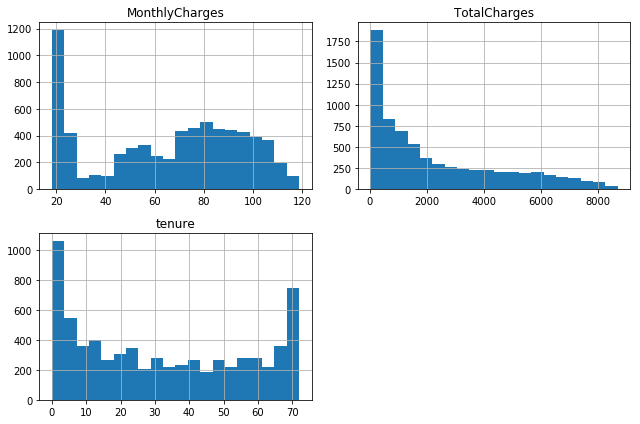

In [3]:
df.hist(figsize = (9,6), bins = 20)
plt.tight_layout()
plt.show()

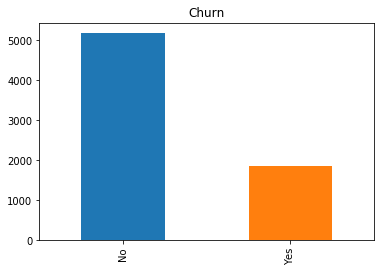

In [4]:
df['Churn'].value_counts().plot(kind='bar')
plt.title('Churn')
plt.show()

## 2.2 {-}

In [5]:
df.drop('customerID', axis=1, inplace=True)
X = df.drop('Churn', axis=1)
y = df['Churn']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

In [7]:
si = SimpleImputer(strategy="mean")
ohe = OneHotEncoder(categories="auto", handle_unknown = 'ignore')
logr = LogisticRegression()
nc = NearestCentroid()
lsvc = LinearSVC()

Xt_cat = X_train.dtypes == object
pipe_prep_cont = Pipeline([('imputer', si)])
pipe_prep_cat = Pipeline([('ohe', ohe)])

prep = ColumnTransformer([('continuous', pipe_prep_cont, ~Xt_cat),('categorical', pipe_prep_cat, Xt_cat)])

pipe_logr = Pipeline([('preprocessing', prep), ('logr', logr)])
pipe_nc = Pipeline([('preprocessing', prep), ('nc', nc)])
pipe_lsvc = Pipeline([('preprocessing', prep), ('lsvc', lsvc)])

s_logr = np.mean(cross_val_score(pipe_logr, X_train, y_train, cv=10))
print("Score for Logistic Regression: " + str(s_logr))

s_nc = np.mean(cross_val_score(pipe_nc, X_train, y_train, cv=10))
print("Score for Nearest Centroid: " + str(s_nc))

s_lsvc = np.mean(cross_val_score(pipe_lsvc, X_train, y_train, cv=10))
print("Score for Linear SVC: " + str(s_lsvc))

Score for Logistic Regression: 0.7962957476755843
Score for Nearest Centroid: 0.5187528865994284
Score for Linear SVC: 0.7001111860490169


The results vary a lot between the different classifiers. Logistic regression works the best, then Linear SVC, and Nearest Centroid performs very poorly. Let's now try with scaling the data.

In [8]:
ssc = StandardScaler()
pipe_prep_cont = Pipeline([('imputer', si), ('scaler', ssc)])
prep = ColumnTransformer([('continuous', pipe_prep_cont, ~Xt_cat),('categorical', pipe_prep_cat, Xt_cat)])

pipe_logr = Pipeline([('preprocessing', prep), ('logr', logr)])
pipe_nc = Pipeline([('preprocessing', prep), ('nc', nc)])
pipe_lsvc = Pipeline([('preprocessing', prep), ('lsvc', lsvc)])

s_logr = np.mean(cross_val_score(pipe_logr, X_train, y_train, cv=10))
print("Score for Logistic Regression with standard scaler: " + str(s_logr))

s_nc = np.mean(cross_val_score(pipe_nc, X_train, y_train, cv=10))
print("Score for Nearest Centroid with standard scaler: " + str(s_nc))

s_lsvc = np.mean(cross_val_score(pipe_lsvc, X_train, y_train, cv=10))
print("Score for Linear SVC with standard scaler: " + str(s_lsvc))

Score for Logistic Regression with standard scaler: 0.7970536814557299
Score for Nearest Centroid with standard scaler: 0.7334444922079615
Score for Linear SVC with standard scaler: 0.7976225806777706


Scaling the data actually significantly improves both Nearest Centroid and SVM. With scaling, Nearest Centroid still performs the worst but linear SVC and Logistic Regression are roughly equivalent. 

## 2.3 {-}

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid_logr = {'logr__C': np.logspace(-3, 2, 6)}
param_grid_nc = {'nc__shrink_threshold': np.linspace(0, 2, 20)}
param_grid_lsvc = {'lsvc__C': np.logspace(-3, 2, 6)}

grid_logr = GridSearchCV(pipe_logr, param_grid_logr, cv=10)
_ = grid_logr.fit(X_train, y_train)

grid_nc = GridSearchCV(pipe_nc, param_grid_nc, cv=10)
_ = grid_nc.fit(X_train, y_train)

grid_lsvc = GridSearchCV(pipe_lsvc, param_grid_lsvc, cv=10)
_ = grid_lsvc.fit(X_train, y_train)

s_logr = grid_logr.best_score_
print("Score for Logistic Regression with Standard Scaling and Grid Search CV: " + str(s_logr))

s_nc = grid_nc.best_score_
print("Score for Nearest Centroids with Standard Scaling and Grid Search CV: " + str(s_nc))

s_lsvc = grid_lsvc.best_score_
print("Score for Linear SVC with Standard Scaling and Grid Search CV: " + str(s_lsvc))

Score for Logistic Regression with Standard Scaling and Grid Search CV: 0.7989397955319955
Score for Nearest Centroids with Standard Scaling and Grid Search CV: 0.733434305187429
Score for Linear SVC with Standard Scaling and Grid Search CV: 0.798750473305566


The results barely improve with GridSearch. It looks like the default parameters give us good enough models. 

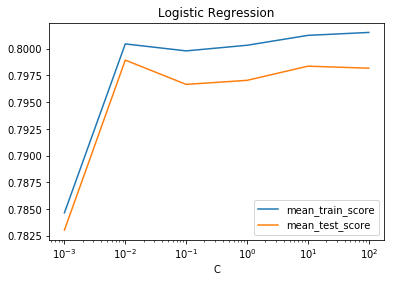

In [10]:
results_logr = pd.DataFrame(grid_logr.cv_results_)
results_logr.plot('param_logr__C', 'mean_train_score')
results_logr.plot('param_logr__C', 'mean_test_score', ax=plt.gca())
plt.legend()
plt.xscale("log")
plt.xlabel("C")
plt.title("Logistic Regression")
plt.show()

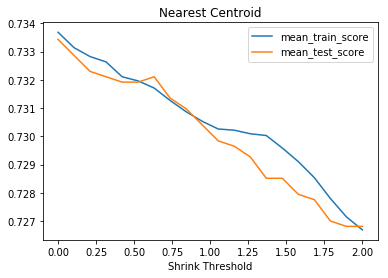

In [11]:
results_nc = pd.DataFrame(grid_nc.cv_results_)
results_nc.plot('param_nc__shrink_threshold', 'mean_train_score')
results_nc.plot('param_nc__shrink_threshold', 'mean_test_score', ax=plt.gca())
plt.legend()
plt.xlabel("Shrink Threshold")
plt.title("Nearest Centroid")
plt.show()

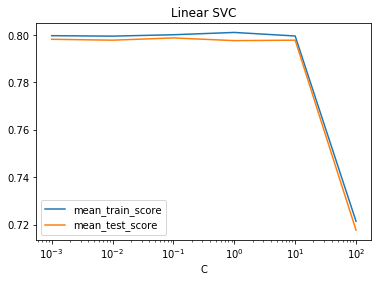

In [12]:
results_lsvc = pd.DataFrame(grid_lsvc.cv_results_)
results_lsvc.plot('param_lsvc__C', 'mean_train_score')
results_lsvc.plot('param_lsvc__C', 'mean_test_score', ax=plt.gca())
plt.legend()
plt.xscale("log")
plt.xlabel("C")
plt.title("Linear SVC")
plt.show()

## 2.4 {-}

Let's first view the parameters currently found by GridSearchCV: 

In [13]:
bp_logr = grid_logr.best_params_
print("Best parameters for Logistic Regression: " + str(bp_logr))

bp_nc = grid_nc.best_params_
print("Best parameters for Nearest Centroids: " + str(bp_nc))

bp_lsvc = grid_lsvc.best_params_
print("Best parameters for Linear SVC: " + str(bp_lsvc))

Best parameters for Logistic Regression: {'logr__C': 0.01}
Best parameters for Nearest Centroids: {'nc__shrink_threshold': 0.0}
Best parameters for Linear SVC: {'lsvc__C': 0.1}


Let's now find them again using a k-fold with shuffling cross-validation.

In [14]:
from sklearn.model_selection import KFold

cvs=KFold(n_splits=10, shuffle=True)

grid_logr = GridSearchCV(pipe_logr, param_grid_logr, cv=cvs)
_ = grid_logr.fit(X_train, y_train)

grid_nc = GridSearchCV(pipe_nc, param_grid_nc, cv=cvs)
_ = grid_nc.fit(X_train, y_train)

grid_lsvc = GridSearchCV(pipe_lsvc, param_grid_lsvc, cv=cvs)
_ = grid_lsvc.fit(X_train, y_train)

bp_logr = grid_logr.best_params_
print("Best parameters for Logistic Regression with k-fold shuffling CV: " + str(bp_logr))

bp_nc = grid_nc.best_params_
print("Best parameters for Nearest Centroids with k-fold shuffling CV: " + str(bp_nc))

bp_lsvc = grid_lsvc.best_params_
print("Best parameters for Linear SVC with k-fold shuffling CV: " + str(bp_lsvc))

Best parameters for Logistic Regression with k-fold shuffling CV: {'logr__C': 0.01}
Best parameters for Nearest Centroids with k-fold shuffling CV: {'nc__shrink_threshold': 0.0}
Best parameters for Linear SVC with k-fold shuffling CV: {'lsvc__C': 0.01}


We can see that the parameters don't change, except for Linear SVC where the best C is now 0.001 instead of 1. However, let's view the corresponding plot:


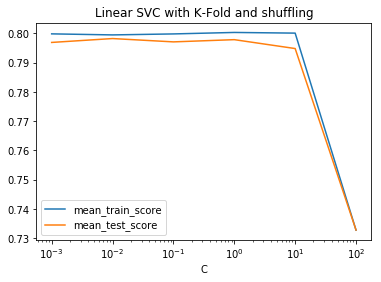

In [15]:
results_lsvc = pd.DataFrame(grid_lsvc.cv_results_)
results_lsvc.plot('param_lsvc__C', 'mean_train_score')
results_lsvc.plot('param_lsvc__C', 'mean_test_score', ax=plt.gca())
plt.legend()
plt.xscale("log")
plt.xlabel("C")
plt.title("Linear SVC with K-Fold and shuffling")
plt.show()

We can see that the difference between 0.001 and 1 is very minimal in terms of performance - as it was in the previous plot. So the change in best parameter isn't really significant.

Let's now add a random state to our K-Fold.

In [16]:
cvs=KFold(n_splits=10, shuffle=True, random_state=1)

grid_logr = GridSearchCV(pipe_logr, param_grid_logr, cv=cvs)
_ = grid_logr.fit(X_train, y_train)

grid_nc = GridSearchCV(pipe_nc, param_grid_nc, cv=cvs)
_ = grid_nc.fit(X_train, y_train)

grid_lsvc = GridSearchCV(pipe_lsvc, param_grid_lsvc, cv=cvs)
_ = grid_lsvc.fit(X_train, y_train)

bp_logr = grid_logr.best_params_
print("Best parameters for Logistic Regression with k-fold shuffling CV and random state on CV: " 
      + str(bp_logr))

bp_nc = grid_nc.best_params_
print("Best parameters for Nearest Centroids with k-fold shuffling CV and random state on CV: " 
      + str(bp_nc))

bp_lsvc = grid_lsvc.best_params_
print("Best parameters for Linear SVC with k-fold shuffling CV and random state on CV: " 
      + str(bp_lsvc))

Best parameters for Logistic Regression with k-fold shuffling CV and random state on CV: {'logr__C': 100.0}
Best parameters for Nearest Centroids with k-fold shuffling CV and random state on CV: {'nc__shrink_threshold': 0.0}
Best parameters for Linear SVC with k-fold shuffling CV and random state on CV: {'lsvc__C': 0.1}


The scores don't change at all from last time - which is reassuring since it means our models are not heavily affected by randomness.

Finally, let's also add a random state for the splitting of the data between train set and test set.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
grid_logr = GridSearchCV(pipe_logr, param_grid_logr, cv=cvs)
_ = grid_logr.fit(X_train, y_train)

grid_nc = GridSearchCV(pipe_nc, param_grid_nc, cv=cvs)
_ = grid_nc.fit(X_train, y_train)

grid_lsvc = GridSearchCV(pipe_lsvc, param_grid_lsvc, cv=cvs)
_ = grid_lsvc.fit(X_train, y_train)

bp_logr = grid_logr.best_params_
print("Best parameters for Logistic Regression with k-fold shuffling CV and random state on CV and train/test split:\n " 
      + str(bp_logr))

bp_nc = grid_nc.best_params_
print("Best parameters for Nearest Centroids with k-fold shuffling CV and random state on CV and train/test split:\n " 
      + str(bp_nc))

bp_lsvc = grid_lsvc.best_params_
print("Best parameters for Linear SVC with k-fold shuffling CV and random state on CV and train/test split:\n " 
      + str(bp_lsvc))

Best parameters for Logistic Regression with k-fold shuffling CV and random state on CV and train/test split:
 {'logr__C': 0.01}
Best parameters for Nearest Centroids with k-fold shuffling CV and random state on CV and train/test split:
 {'nc__shrink_threshold': 0.0}
Best parameters for Linear SVC with k-fold shuffling CV and random state on CV and train/test split:
 {'lsvc__C': 0.001}


This time, the best C parameter for Logistic Regression changes from 1 to 0.01. But again, let's plot the evolution of the scores according to that parameter:

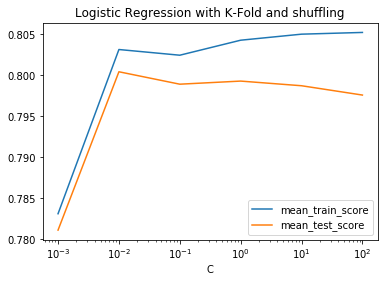

In [18]:
results_logr = pd.DataFrame(grid_logr.cv_results_)
results_logr.plot('param_logr__C', 'mean_train_score')
results_logr.plot('param_logr__C', 'mean_test_score', ax=plt.gca())
plt.legend()
plt.xscale("log")
plt.xlabel("C")
plt.title("Logistic Regression with K-Fold and shuffling")
plt.show()

Again, we can see that the curve is rougly constant from 0.01 on, so it's not really a surprise that a slight change (e.g. changing the train-test split) would affect the maximum of the curve, since it's always going to be on that straight line between 0.01 and 100.

## 2.5 {-}

We display a 'dot plot' of feature coefficients for both models.

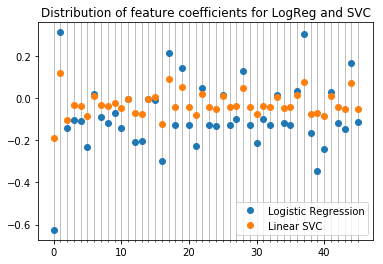

In [19]:
coeffs_logr = grid_logr.best_estimator_.named_steps['logr'].coef_
coeffs_lsvc = grid_lsvc.best_estimator_.named_steps['lsvc'].coef_
plt.plot(coeffs_logr[0], 'o', label='Logistic Regression')
plt.plot(coeffs_lsvc[0], 'o', label='Linear SVC')
plt.legend()
ax = plt.gca()
ax.set_xticks(range(len(coeffs_logr[0])), minor=True)
plt.gca().xaxis.grid(True, which='minor')
plt.title("Distribution of feature coefficients for LogReg and SVC")
plt.show()

We can wee that the general distribution of the feature coefficients is roughly similar between the two models (in particular, features 1, 17, 19, 37 and 44 are important in both), even though the amplitude of the coefficients is generally larger in Logistic Regression.